In [1]:
import pygrib
import gzip
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from scipy import interpolate

# Visualization

1:Total Precipitation:kg m**-2 (accum):polar_stereographic:surface:level 0:fcst time 0-1 hrs (accum):from 201207311300


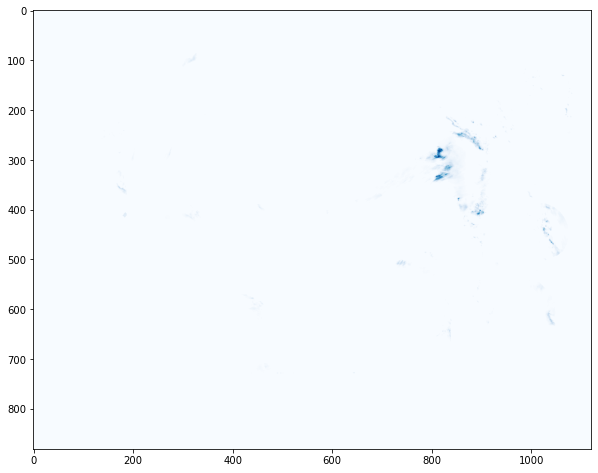

In [4]:
gr = pygrib.open('StageIV/ST4.2012073114.01h')
for g in gr:
    print(g)
data = gr[1].values.data
data[data > 9000] = 0

fig = plt.figure(figsize=(10,10))
plt.imshow(data, cmap='Blues')
plt.show()

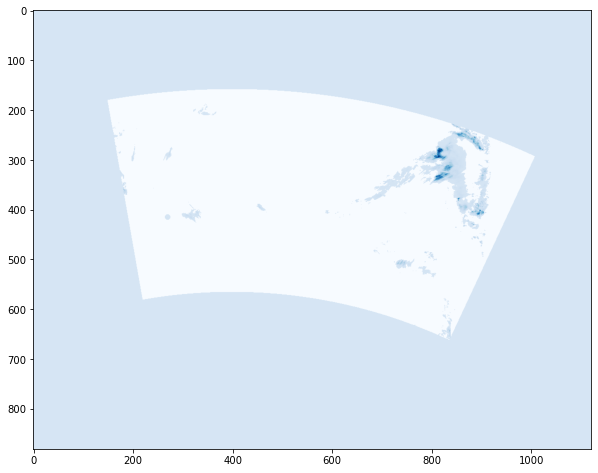

In [6]:
# crop
lat = gr[1].latlons()[0]
long = gr[1].latlons()[1]
long_range = (-115, -80)
lat_range = (30, 45)

mask_lat_RegC = (np.min(lat_range) <= lat) * (lat <= np.max(lat_range))
mask_long_RegC = (np.min(long_range) <= long) * (long <= np.max(long_range))

mask = mask_lat_RegC * mask_long_RegC

data[data == 0] = -20
data = data * mask

fig = plt.figure(figsize=(10, 10))
plt.imshow(data, cmap='Blues')
plt.show()

# Project and interpolation function

In [11]:
# 整合
def get_proj_data(file_path: str, long_range: tuple, lat_range: tuple):
    gr = pygrib.open(file_path)
    data = gr[1].values.data
    data[data > 9000] = 0
    lat = np.array(gr[1].latlons()[0])
    long = np.array(gr[1].latlons()[1])
    
    # select Reg
    mask_lat_C = (np.min(lat_range) <= lat) *  (lat <= np.max(lat_range))
    mask_long_C = (np.min(long_range) <= long) *  (long <= np.max(long_range))
    mask = mask_lat_C * mask_long_C
    y, x = np.nonzero(mask) # indices of selected region
    
    # proj to regular grid
    toGridIndex = lambda x, rang: ((x - x.min()) / (x.max() - x.min()) * rang).astype(int)
    width = int((np.max(lat_range) - np.min(lat_range)) / 0.04)
    length = int((np.max(long_range) - np.min(long_range)) / 0.04)
    lons_grid_index = toGridIndex(long[mask], length)
    lats_grid_index = toGridIndex(lat[mask], width)
    grid = np.zeros((lats_grid_index.max(), lons_grid_index.max())) # regular grid
    grid[grid == 0] = -1
    N = np.zeros_like(grid) # counter
    
    for i in range(x.shape[0]):
        if grid[lats_grid_index[i]-1, lons_grid_index[i]-1] == -1:
            grid[lats_grid_index[i]-1, lons_grid_index[i]-1] = 0
            grid[lats_grid_index[i]-1, lons_grid_index[i]-1] += data[y[i],x[i]]
            N[lats_grid_index[i]-1, lons_grid_index[i]-1] += 1
        else:
            grid[lats_grid_index[i]-1, lons_grid_index[i]-1] += data[y[i],x[i]]
            N[lats_grid_index[i]-1, lons_grid_index[i]-1] += 1
    
    projected = grid / (N + 1e-10)
    mask = projected < 0
    projected[mask] = 0
    
    # interpolation with linear method
    a, b = np.nonzero(~mask)
    values = projected[a, b]
    grid_x, grid_y = np.mgrid[0:374:375j, 0:874:875j]
    grid_z = interpolate.griddata((a, b), values, (grid_x, grid_y), method='linear')
    return grid_z

## Test

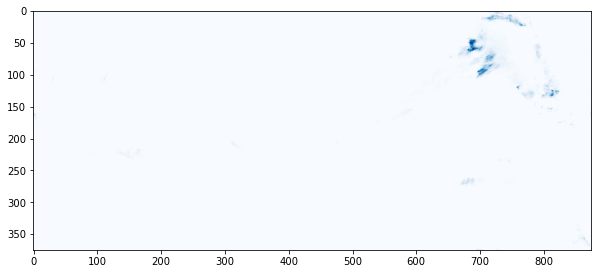

In [29]:
long_range = (-115, -80)
lat_range = (30, 45)
dir_path = '/usr/commondata/New/StageIV/'
file_name = 'ST4.2012073114.01h'

data = get_proj_data(dir_path+file_name, long_range, lat_range)
fig = plt.figure(figsize=(10, 10))
plt.imshow(data, cmap='Blues')
plt.show()

# Main function

In [35]:
long_range = (-115, -80)
lat_range = (30, 45)
csv_path = '/usr/commondata/weather/IR_data/tabels/train.csv'

# 
dataset = {}
filenames = pd.read_csv(csv_path)['y']
for f in filenames:
    if pd.notna(f):
        name_info = f.split('.')
        key = name_info[0][-3:]+'.'+name_info[1]
        print(key)
        content = np.load(f)['arr_0']
        dataset[key] = content

193.21
168.15
161.22
203.04
196.13
201.00
189.22
171.12
198.05
194.14
159.20
164.10
191.13
155.03
167.21
210.03
165.09
156.03
173.16
168.08
192.06
213.03
163.12
160.00
183.12
155.10
210.07
179.21
172.13
180.17
209.12
196.12
190.17
183.22
174.18
172.15
182.11
183.15
207.09
165.21
179.22
179.13
187.03
180.04
191.15
202.20
153.12
210.08
159.14
205.19
156.16
170.18
166.19
167.14
163.06
161.06
185.07
204.23
193.00
153.01
158.13
188.20
171.09
203.08
174.14
156.11
185.23
158.14
170.19
198.13
184.05
160.18
180.22
160.21
193.23
181.08
161.20
172.02
197.17
164.08
195.13
208.04
203.18
209.00
193.19
166.21
170.09
181.01
170.10
202.21
212.11
207.13
194.03
183.10
154.12
213.00
209.21
200.20
178.11
175.05
205.13
162.08
165.06
194.18
178.10
191.20
199.16
154.18
210.13
155.15
204.17
163.19
187.04
158.02
213.05
179.14
193.01
165.22
191.01
180.19
199.14
191.12
213.19
195.04
165.12
154.22
165.01
190.05
187.00
172.22
162.12
159.00
169.21
199.10
185.22
178.20
170.03
194.17
193.02
186.10
181.21
173.05
172.09

158.23
163.02
207.06
190.21
154.00
176.13
171.07
180.08
187.19
193.20
159.11
191.08
166.04
156.02
210.14
190.20
170.15
178.13
158.04
201.04
165.16
163.05
191.09
199.04
168.21
178.01
171.04
170.06
165.03
158.16
205.15
158.11
200.00
180.18
162.11
168.07
204.07
165.14
206.11
176.12
173.09
195.14
155.16
195.07
183.09
211.18
174.23
186.09
164.12
162.07
173.14
163.10
182.15
189.09
165.13
153.19
206.13
203.20
201.14
161.07
193.13
200.05
195.22
162.14
169.00
208.02
191.22
211.02
194.10
196.10
166.05
207.20
199.19
187.12
175.06
182.19
197.02
166.13
163.18
155.02
191.04
206.19
158.03
207.01
213.01
156.20
190.01
208.08
160.22
173.20
164.20
192.11
190.09
189.00
197.14
169.01
158.01
175.10
184.23
195.21
167.09
197.18
186.04
167.05
158.15
158.12
192.15
160.03
178.18
197.12
211.14
203.14
187.08
160.01
186.15
169.20
206.00
191.02
164.16
168.13
186.14
195.23
186.18
201.19
181.12
205.06
199.22
202.06
206.15
189.19
198.06
165.04
165.00
212.21
192.07
158.22
189.05
203.23
213.14
206.16
182.23
213.21
206.10

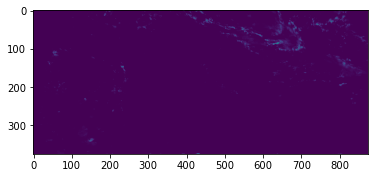

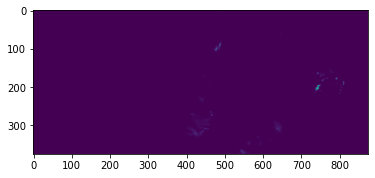

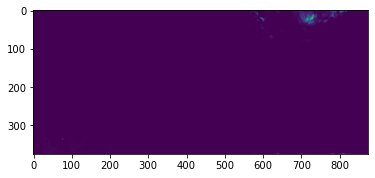

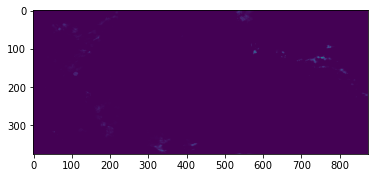

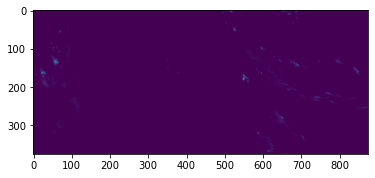

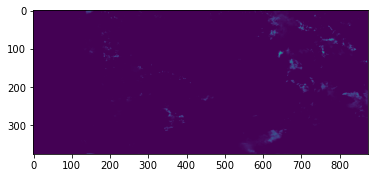

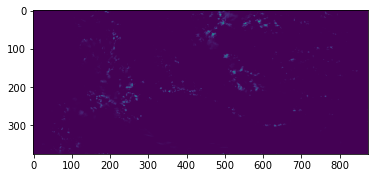

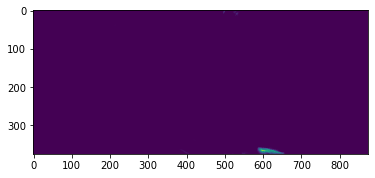

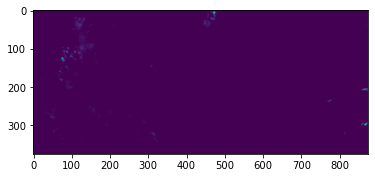

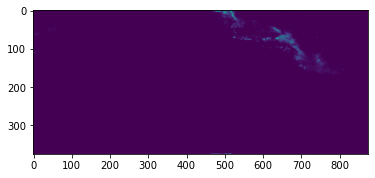

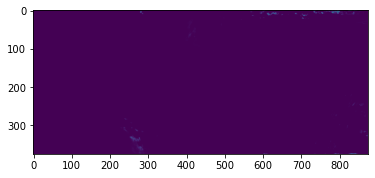

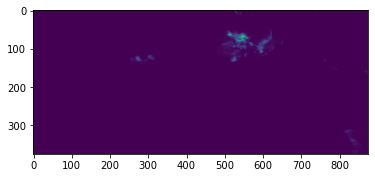

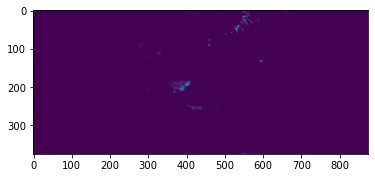

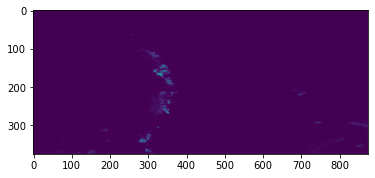

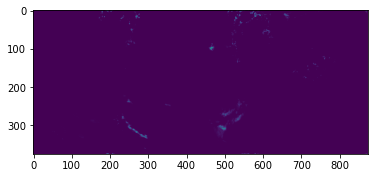

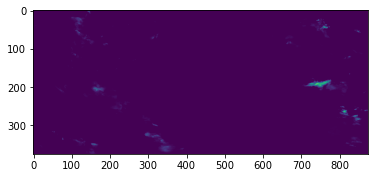

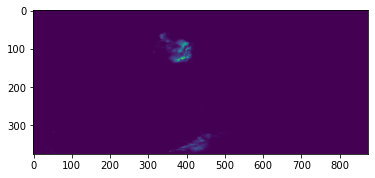

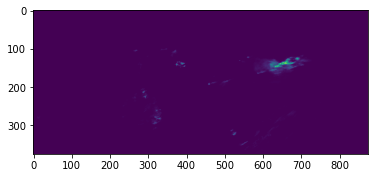

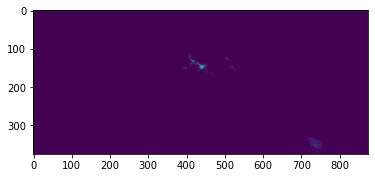

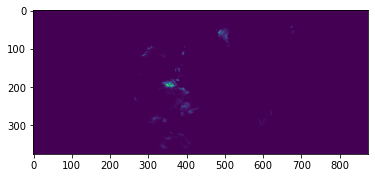

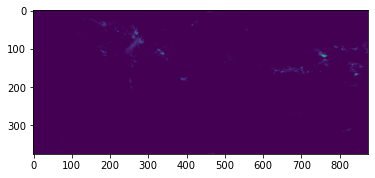

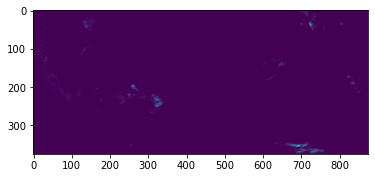

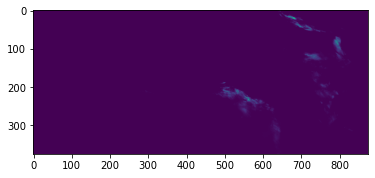

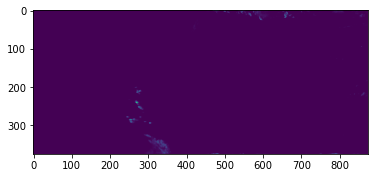

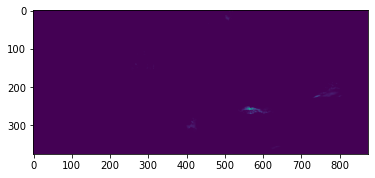

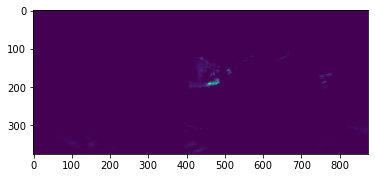

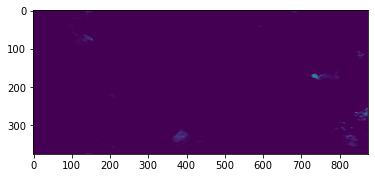

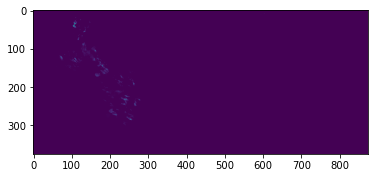

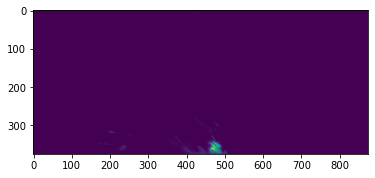

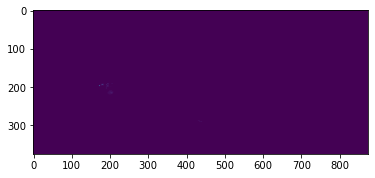

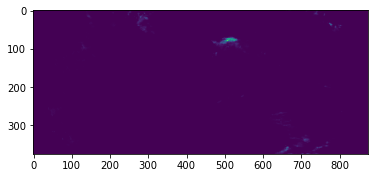

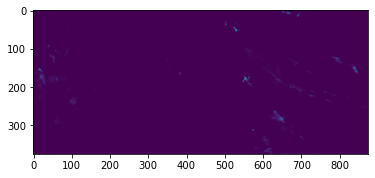

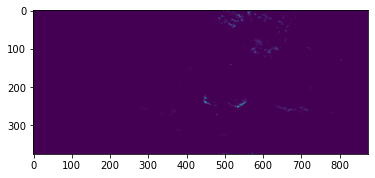

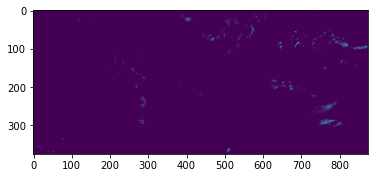

KeyboardInterrupt: 

In [36]:
for k, v in dataset.items():
    plt.imshow(v)
    plt.show()
    plt.close()